In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
import itertools
import helpers
%load_ext autoreload
%autoreload 2

## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [2]:
from helpers import load_data, preprocess_data

path_dataset = "movielens100k.csv"
ratings = load_data(path_dataset)

number of items: 1682, number of users: 943


In [3]:
ratings.shape

(1682, 943)

In [4]:
n_test = int(ratings.nnz * 0.1)
ind = np.arange(ratings.nnz)
np.random.shuffle(ind)
ind[:n_test]

array([67489, 43798,  6242, ..., 37482, 77674, 37182])

### Plot the number of ratings per movie and user

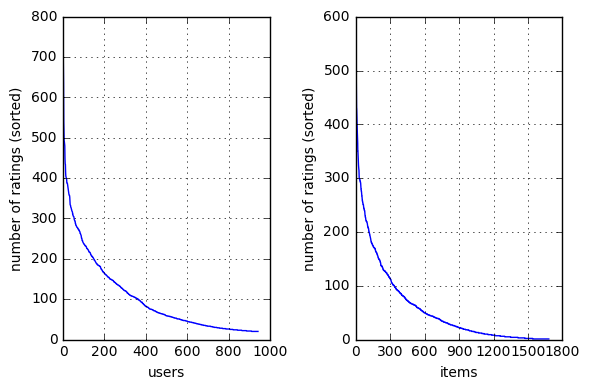

min # of items per user = 20, min # of users per item = 1.


In [5]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))




### Split the data into a train and test set

In [6]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(22)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]  
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data and return train and test data. TODO
    # NOTE: we only consider users and movies that have more
    # than 10 ratings
    # ***************************************************
    
    # initiate empty test matrix and full train matrix
    test = sp.lil_matrix(valid_ratings.shape, dtype = np.float64)
    train = sp.lil_matrix.copy(valid_ratings)
    
    # number of test elements
    n_test = int(train.nnz * p_test)
    ind = np.arange(train.nnz)
    np.random.shuffle(ind)
    ind = ind[:n_test] # list of 10% of indicies between 0 and nnz
    
    rows, cols = train.nonzero()
    
    for i in ind:
        # get right coordonate
        row = rows[i]
        col = cols[i]
        
        # put this into test matrix
        test[row, col] = valid_ratings[row, col]
        
        # clear it from train matrix
        train[row, col] = 0.

    
    print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

Total number of nonzero elements in origial data:99999
Total number of nonzero elements in train data:88157
Total number of nonzero elements in test data:9795


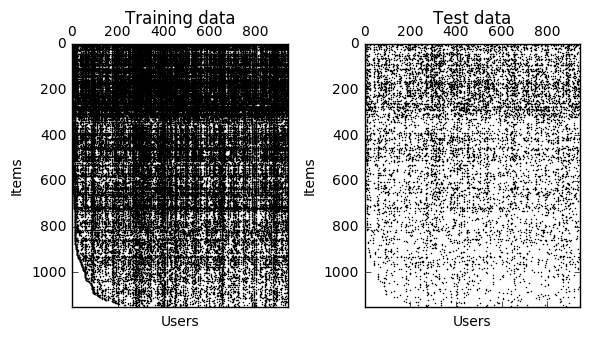

In [7]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)
plot_train_test_data(train, test)

## Implementing Baselines 

### Use the global mean to do the prediction

In [8]:
def nonzero_mean(matrix):
    return matrix.sum() / matrix.nnz

In [13]:
def rmse(predicted, testset):
    res = testset - predicted
    res = res.dot(res.T)
    res = nonzero_mean(res)
    res = np.sqrt(res)
    return res

In [14]:
from helpers import calculate_mse

def baseline_global_mean(train, test):
    """baseline method: use the global mean."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # ***************************************************    
    
    # Global mean
    mean = nonzero_mean(train)
    prediction = sp.lil_matrix(train.shape, dtype = np.float64)
    row, col = test.nonzero()
    
    for i,j in zip(row, col):
        prediction[i, j] = mean
        
    return rmse(prediction, test)
    

baseline_global_mean(train, test)

0.56865474542373229

### Use the user means as the prediction

In [163]:
from collections import defaultdict

def counter(matrix, axis):
    n_row = matrix.nonzero()[axis]

    d = defaultdict(int)
    for i in n_row:
        d[i] += 1
    return d

def nonzero_row_mean(matrix):
    size = train.shape[0]
    res = np.zeros(size)
    sum_ = matrix.sum(axis = 1)
    n_ = counter(matrix, axis =0 )
    
    for i in range(size):
        a = sum_[i] / n_[i] 
        res[i] = a
        
    return res

def nonzero_column_mean(matrix):
    size = train.shape[1]
    res = np.zeros(size)
    sum_ = matrix.sum(axis = 0)
    n_ = counter(matrix, axis =1 )

    for i in range(size):
        a = sum_[:,i] / n_[i] 
        res[i] = a
        
    return res

In [169]:
def baseline_user_mean(train, test):
    """baseline method: use the user means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # ***************************************************
    user_mean = nonzero_row_mean(train)
    
    prediction = sp.lil_matrix(train.shape, dtype = np.float64)
    row, col = test.nonzero()
    
    for i,j in zip(row, col):
        prediction[i, j] = user_mean[i]
        
    return rmse(prediction, test)

baseline_user_mean(train, test)

0.52045150608852186

### Use the item means as the prediction

In [170]:
def baseline_item_mean(train, test):
    """baseline method: use item means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # ***************************************************
    item_mean = nonzero_column_mean(train)
    
    prediction = sp.lil_matrix(train.shape, dtype = np.float64)
    row, col = test.nonzero()
    
    for i,j in zip(row, col):
        prediction[i, j] = item_mean[j]
        
    return rmse(prediction, test)
    
baseline_item_mean(train, test)

0.28142388387103856

### Some estimation:

In [171]:
valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)

print(baseline_global_mean(train, test))
print(baseline_item_mean(train, test))
print(baseline_user_mean(train, test))

Total number of nonzero elements in origial data:99999
Total number of nonzero elements in train data:88157
Total number of nonzero elements in test data:9795
0.568654745424
0.281423883871
0.520451506089


### Learn the Matrix Factorization using SGD

#### Initialize matrix factorization

In [174]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # you should return:
    #     user_features: shape = num_user, num_features (matrix Z)
    #     item_features: shape = num_item, num_features (matrix W)
    # ***************************************************
    
    num_item, num_user = train.shape
    
    user_features = sp.lil_matrix((num_user, num_features), dtype=np.float64)
    item_features = sp.lil_matrix((num_item, num_features), dtype=np.float64)
    
    return user_features, item_features

Compute the cost by the method of matrix factorization.


In [172]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (RMSE) of the prediction of nonzero elements."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # calculate rmse (we only consider nonzero entries.)
    # ***************************************************
    pred = np.dot(item_features, user_features.T)
    
    row, col = data.nonzeros()
    square_errors = 0
    for i,j in zip(row, col):
        square_errors += np.square(data[i,j] - pred[i,j])
        
    mse = np.mean(square_errors)
    rmse = np.sqrt(mse)
    return mse
    
    

In [173]:
def matrix_factorization_SGD(train, test):
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.01
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    #num_epochs = 20     # number of full passes through the train set
    num_epochs = 1
    errors = [0]
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))

    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2
        
        for d, n in nz_train:
        # d: train_rows, n: train_columns
        
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO
        # do matrix factorization.
        # ***************************************************
        raise NotImplementedError

        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        
        errors.append(rmse)
    # ***************************************************
    # TODO
    # evaluate the test error.
    # ***************************************************
    rmse = compute_error(test, user_features, item_features, nz_test)
    print("RMSE on test data: {}.".format(rmse))


matrix_factorization_SGD(train, test)   

IndentationError: expected an indented block (<ipython-input-173-bfb0aad9d4e8>, line 37)

### Learn the Matrix Factorization using Alternating Least Squares

In [ ]:
def update_user_feature(
        train, item_features, lambda_user,
        nnz_items_per_user, nz_user_itemindices):
    """update user feature matrix."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # update and return user feature.
    # ***************************************************
    raise NotImplementedError

def update_item_feature(
        train, user_features, lambda_item,
        nnz_users_per_item, nz_item_userindices):
    """update item feature matrix."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # update and return item feature.
    # ***************************************************
    raise NotImplementedError

In [ ]:
from helpers import build_index_groups


def ALS(train, test):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    stop_criterion = 1e-4
    change = 1
    error_list = [0, 0]
    
    # set seed
    np.random.seed(988)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # start you ALS-WR algorithm.
    # ***************************************************
    raise NotImplementedError

ALS(train, test)